In [1]:
%load_ext autoreload
%autoreload 
from DNC_predict import predict_label, pre_matt
import numpy as np
import glob

In [2]:
def accuracy(pairs_nx3: np.ndarray, pairs_gt_mx3: np.ndarray):
    if len(pairs_gt_mx3)==0:
        print("Warning: no ground truth data!")
        return

    common_elements, common_idx1, common_idx2 = np.intersect1d(pairs_nx3[:, 0], pairs_gt_mx3[:, 0],
                                                               return_indices=True)

    pairs_col_2 = pairs_nx3[common_idx1, 1]
    pairs_gt_col_2 = pairs_gt_mx3[common_idx2, 1]
    idx = np.nonzero(pairs_col_2==pairs_gt_col_2)[0]
   # print(pairs_nx3[common_idx1][idx])
    return len(idx)/len(pairs_gt_mx3)


def ids_to_pairs(ids_1: np.ndarray, ids_2: np.ndarray) -> np.ndarray:
    """Generate ground truth of pairs from test_tracking data in https://osf.io/t7dzu/

    Notes
    -----
    The ids can be obtained from points[:, 3] loaded from the .npy files.
    The value -1 means the cell is not tracked. Other values (>=0) means the identified numeric id.
    """
    array1, array2 = ids_1.astype(int), ids_2.astype(int),
    filtered_array1 = array1[array1 != -1]
    filtered_array2 = array2[array2 != -1]

    # 找出相同元素及其在两个数组中的位置
    common_elements, common_idx1, common_idx2 = np.intersect1d(filtered_array1, filtered_array2, return_indices=True)

    # 对 array1, 2 进行排序，并记录原始索引
    sorted_indices_1 = np.argsort(array1)
    sorted_arr1 = array1[sorted_indices_1]
    sorted_indices_2 = np.argsort(array2)
    sorted_arr2 = array2[sorted_indices_2]

    # 使用 searchsorted 找到插入位置
    insert_positions_1 = np.searchsorted(sorted_arr1, common_elements)
    insert_positions_2 = np.searchsorted(sorted_arr2, common_elements)

    # 使用原始索引获取实际位置
    original_idx1 = sorted_indices_1[insert_positions_1]
    original_idx2 = sorted_indices_2[insert_positions_2]

    # 根据reference points的编号进行排序
    sorted_indices = np.argsort(original_idx1)
    pairs_gt = np.column_stack((original_idx1[sorted_indices], original_idx2[sorted_indices]))
    return pairs_gt

In [3]:
def extract_number(filename):
    import re
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    return None

npy_files = glob.glob("../fDNC_Data/test_tracking/real_jeff_all" + "/real_*.npy")
sorted_npy_files = sorted(npy_files, key=extract_number)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch


def plot_initial_matching(ref_ptrs, tgt_ptrs, pairs_px2, t1: int, t2: int, ref_ptrs_confirmed=None,
                          fig_width_px=1800, dpi=96, ids_ref=None, ids_tgt=None, show_3d: bool = False, display_fig=True):
    """Draws the initial matching between two sets of 3D points and their matching relationships.

    Args:
        ref_ptrs (ndarray): A 2D array of shape (n, 3) containing the reference points.
        tgt_ptrs (ndarray): A 2D array of shape (n, 3) containing the target points.
        pairs_px2 (ndarray): A 2D array of shape (m, 2) containing the pairs of matched points.
        fig_width_px (int): The width of the output figure in pixels. Default is 1200.
        dpi (int): The resolution of the output figure in dots per inch. Default is 96.

    Raises:
        AssertionError: If the inputs have invalid shapes or data types.
    """
    if show_3d:
        fig = plot_matching_with_arrows_3d_plotly(ref_ptrs, tgt_ptrs, pairs_px2, ids_ref, ids_tgt)
        return fig
    # Plot the scatters of the ref_points and tgt_points
    ax1, ax2, fig = plot_two_pointset_scatters(dpi, fig_width_px, ref_ptrs, tgt_ptrs, t1, t2, ids_ref, ids_tgt)

    # Plot the matching relationships between the two sets of points
    for ref_index, tgt_index in pairs_px2:
        # Get the coordinates of the matched points in the two point sets
        pt1 = np.asarray([ref_ptrs[ref_index, 1], ref_ptrs[ref_index, 0]])
        pt2 = np.asarray([tgt_ptrs[tgt_index, 1], tgt_ptrs[tgt_index, 0]])

        # Draw a connection between the matched points in the two subplots using the `ConnectionPatch` class
        con = ConnectionPatch(xyA=pt2, xyB=pt1, coordsA="data", coordsB="data",
                              axesA=ax2, axesB=ax1, color="C1")
        ax2.add_artist(con)
    if ref_ptrs_confirmed is not None:
        ax1.scatter(ref_ptrs_confirmed[:, 1], ref_ptrs_confirmed[:, 0], facecolors='r', edgecolors='r', label='Confirmed cells')
    if display_fig:
        plt.pause(0.1)
    return fig


def plot_two_pointset_scatters(dpi: float, fig_width_px: float, ref_ptrs, tgt_ptrs, t1: int, t2: int,
                               ids_ref: list = None, ids_tgt: list = None):
    """
    Creates a figure with two subplots showing two sets of 3D points.

    Parameters
    ----------
    dpi : float
        The resolution of the output figure in dots per inch.
    fig_width_px : float
        The width of the output figure in pixels.
    ref_ptrs : ndarray
        A 2D array of shape (n, 3) containing the positions of reference points.
    tgt_ptrs : ndarray
        A 2D array of shape (n, 3) containing the positions of target points.
    t1 : int
        The time step of the reference points.
    t2 : int
        The time step of the target points.
    ids_ref : list, optional
        A list of strings containing the IDs of the reference points. Default is None.
    ids_tgt : list, optional
        A list of strings containing the IDs of the target points. Default is None.

    Returns
    -------
    ax1 : matplotlib.axes.Axes
        The first Axes object of the subplots.
    ax2 : matplotlib.axes.Axes
        The second Axes object of the subplots.
    fig : matplotlib.figure.Figure
        The Figure object containing the two subplots.
    """
    # Calculate the figure size based on the input width and dpi
    fig_width_in = fig_width_px / dpi  # convert to inches assuming the given dpi
    fig_height_in = fig_width_in / 2.2  # set height to golden ratio
    # Determine whether to use a top-down or left-right layout based on the aspect ratio of the point sets
    ref_range_y, ref_range_x, _ = np.max(ref_ptrs, axis=0) - np.min(ref_ptrs, axis=0)
    tgt_range_y, tgt_range_x, _ = np.max(tgt_ptrs, axis=0) - np.min(tgt_ptrs, axis=0)
    # top_down = ref_range_x + tgt_range_x >= ref_range_y + tgt_range_y
    top_down = True

    ids_ref = range(1, ref_ptrs.shape[0]+1) if ids_ref is None else ids_ref
    ids_tgt = range(1, tgt_ptrs.shape[0]+1) if ids_tgt is None else ids_tgt

    # Create the figure and subplots
    if top_down:
        # print("Using top-down layout")
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_height_in, fig_width_in))
    else:
        # print("Using left-right layout")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width_in, fig_height_in))

    # Plot the point sets on the respective subplots
    ax1.scatter(ref_ptrs[:, 1], ref_ptrs[:, 0], facecolors='b', edgecolors='b', label='Set 1')
    for i, txt in enumerate(ids_ref):
        ax1.annotate(txt, (ref_ptrs[i, 1], ref_ptrs[i, 0]))

    ax2.scatter(tgt_ptrs[:, 1], tgt_ptrs[:, 0], facecolors='b', edgecolors='b', label='Set 2')
    for i, txt in enumerate(ids_tgt):
        ax2.annotate(txt, (tgt_ptrs[i, 1], tgt_ptrs[i, 0]))

    unify_xy_lims(ax1, ax2)

    # Set plot titles or y-axis labels based on the layout
    if top_down:
        ax1.set_ylabel(f"Point Set t={t1}")
        ax2.set_ylabel(f"Point Set t={t2}")
    else:
        ax1.set_title(f"Point Set t={t1}")
        ax2.set_title(f"Point Set t={t2}")
    return ax1, ax2, fig


def unify_xy_lims(ax1, ax2):
    """
    Set the x and y limits of two matplotlib axes to be the same.

    Parameters
    ----------
    ax1 : matplotlib.axes.Axes
        The first Axes object.
    ax2 : matplotlib.axes.Axes
        The second Axes object.
    """
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    # Determine the shared x_lim and y_lim
    x_lim = [min(ax1.get_xlim()[0], ax2.get_xlim()[0]), max(ax1.get_xlim()[1], ax2.get_xlim()[1])]
    y_lim = [min(ax1.get_ylim()[1], ax2.get_ylim()[1]), max(ax1.get_ylim()[0], ax2.get_ylim()[0])]
    range_x = x_lim[1] - x_lim[0]
    range_y = y_lim[1] - y_lim[0]
    if range_y > range_x:
        x_mean = (x_lim[1] + x_lim[0]) / 2
        x_lim = [x_mean - range_y / 2, x_mean + range_y / 2]
    else:
        y_mean = (y_lim[1] + y_lim[0]) / 2
        y_lim = [y_mean - range_x / 2, y_mean + range_x / 2]

    # Set the same x_lim and y_lim on both axes
    ax1.set_xlim(x_lim[0], x_lim[1])
    ax1.set_ylim(y_lim[1], y_lim[0])
    ax2.set_xlim(x_lim[0], x_lim[1])
    ax2.set_ylim(y_lim[1], y_lim[0])

/home/wen/PycharmProjects/3DeeCellTracker/Examples/use_fpm_stardist/fDNC/model.py:598: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  sents_var = torch.tensor(sents_padded, dtype=torch.float, device=self.device)


0.7346938775510204


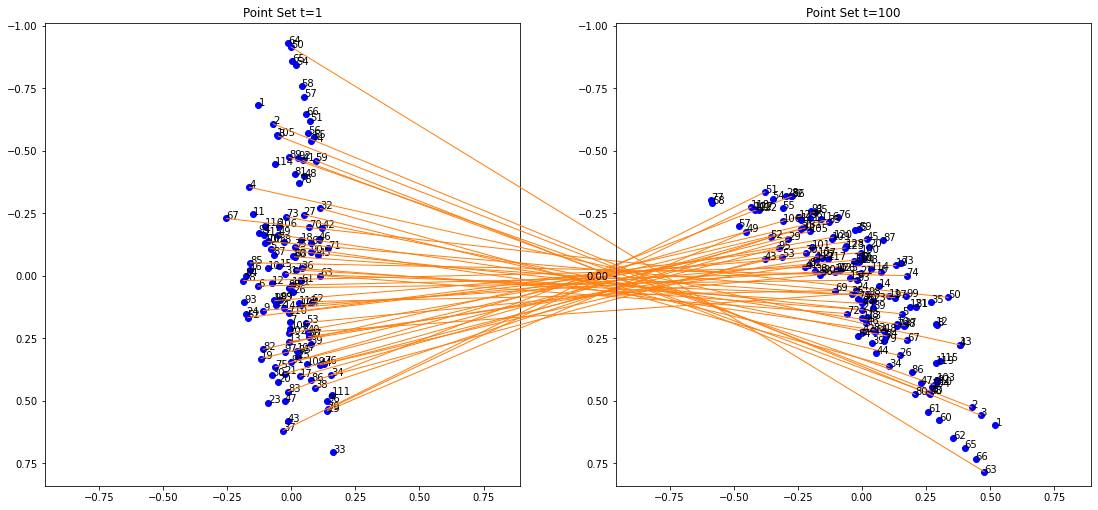

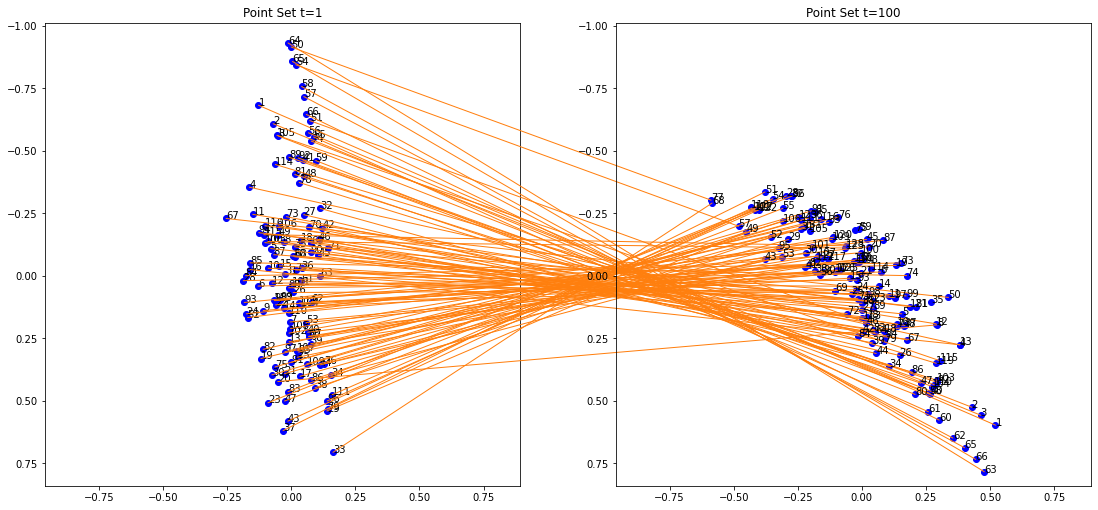

In [5]:
i=1
i2=100
points1 = np.load(sorted_npy_files[i-1])
points2 = np.load(sorted_npy_files[i2-1])
pred_test_label, _ = predict_label(temp_pos=points1[:, :3], 
                              temp_label=np.arange(points1.shape[0]), 
                              test_pos=points2[:, :3], 
                              temp_color=None, cuda=False)
pairs_gt = ids_to_pairs(points1[:, 3],points2[:, 3])
pairs_pred = np.asarray([(idx, i)for i, (idx, p) in enumerate(pred_test_label) if p > 0])
print(accuracy(pairs_pred, pairs_gt))
fig = plot_initial_matching(points1[:, :3],points2[:, :3], pairs_gt, i, i2)
fig = plot_initial_matching(points1[:, :3],points2[:, :3], pairs_pred, i, i2)

In [29]:
from sklearn.decomposition import PCA
import h5py

def load_normalized_coords(t: int):
    segmented_pos = _get_segmented_pos(t)
    mean = np.mean(segmented_pos, axis=0)
    pca = PCA(n_components=1)
    pca.fit(segmented_pos)
    std = np.std(pca.transform(segmented_pos)[:, 0])

    return (segmented_pos - mean) / (std*3), segmented_pos


def _get_segmented_pos(t: int):
    """Get segmented positions and extra positions from stardist model"""
    path_results = "/home/wen/BIG_DATA_1/Mikami_free_moving_worm/20231218/tracking_results_fpm_ensemble/seg.h5"

    with h5py.File(path_results, "r") as seg_file:
        coordinates_stardist = seg_file[f'coords_{str(t-1).zfill(6)}'][:]
    return coordinates_stardist

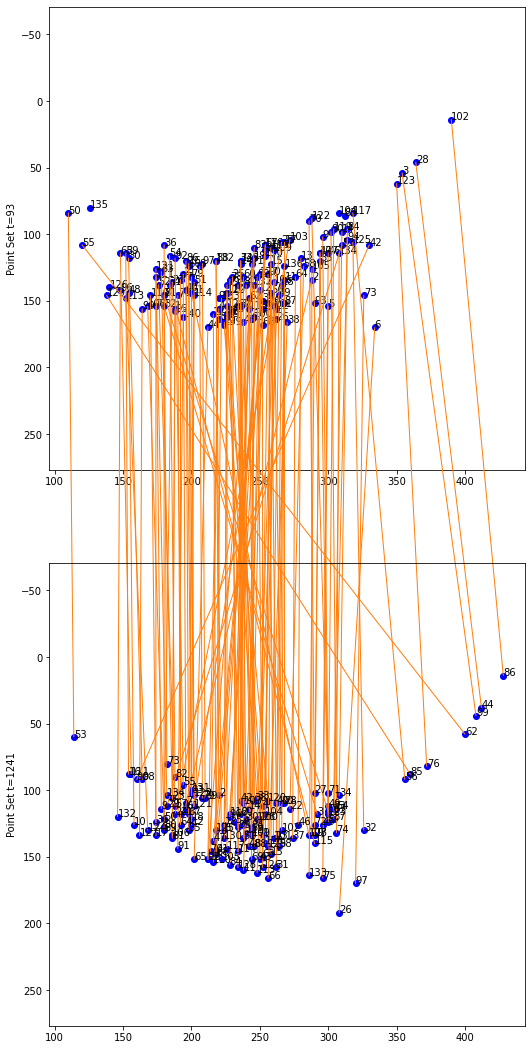

In [36]:
i=93
i2=1241
points1, segmented_pos1 = load_normalized_coords(i)
points2, segmented_pos2 = load_normalized_coords(i2)
pred_test_label, _ = predict_label(temp_pos=points1[:, :3], 
                              temp_label=np.arange(points1.shape[0]), 
                              test_pos=points2[:, :3], 
                              temp_color=None, cuda=False)
pairs_pred = np.asarray([(idx, i)for i, (idx, p) in enumerate(pred_test_label) if p > 0])
fig = plot_initial_matching(segmented_pos1[:, :3],segmented_pos2[:, :3], pairs_pred, i, i2)

In [24]:
from sklearn.decomposition import PCA
import h5py

def load_normalized_coords(t: int):
    segmented_pos = _get_segmented_pos(t)
    mean = np.mean(segmented_pos, axis=0)
    pca = PCA(n_components=1)
    pca.fit(segmented_pos)
    std = np.std(pca.transform(segmented_pos)[:, 0])

    return (segmented_pos - mean) / (std*3), segmented_pos


def _get_segmented_pos(t: int):
    """Get segmented positions and extra positions from stardist model"""
    path_results = "/home/wen/BIG_DATA_1/Suzuki_nwb_files/231013-02/results/seg.h5"

    with h5py.File(path_results, "r") as seg_file:
        coordinates_stardist = seg_file[f'coords_{str(t-1).zfill(6)}'][:]
    return coordinates_stardist

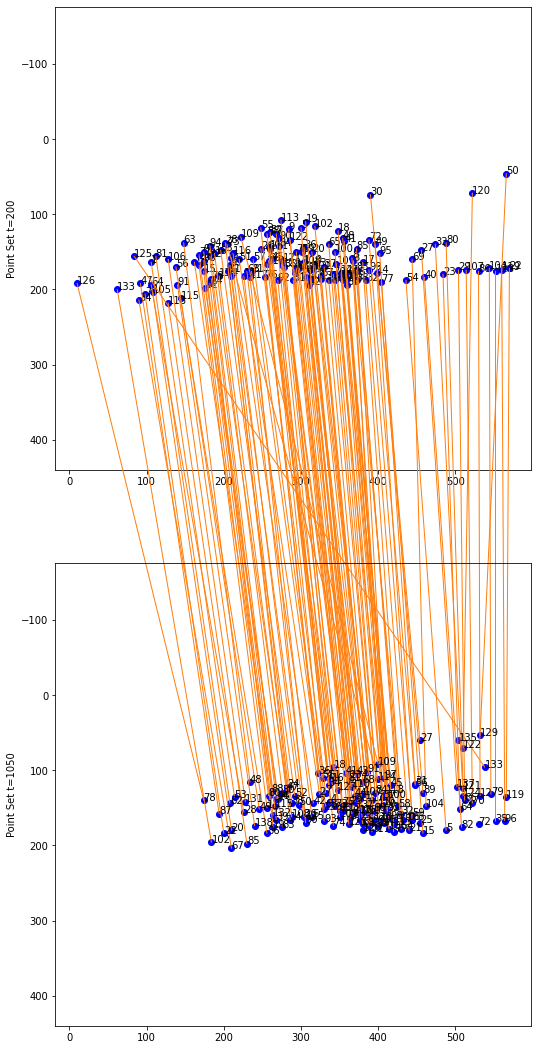

In [28]:
i=200
i2=1050
points1, segmented_pos1 = load_normalized_coords(i)
points2, segmented_pos2 = load_normalized_coords(i2)
pred_test_label, _ = predict_label(temp_pos=points1[:, :3], 
                              temp_label=np.arange(points1.shape[0]), 
                              test_pos=points2[:, :3], 
                              temp_color=None, cuda=False)
pairs_pred = np.asarray([(idx, i)for i, (idx, p) in enumerate(pred_test_label) if p > 0])
fig = plot_initial_matching(segmented_pos1[:, :3],segmented_pos2[:, :3], pairs_pred, i, i2)

## The accuracy on a training data set

In [47]:
import glob
npy_files = glob.glob("../fDNC_Data/test_tracking/real_jeff_all" + "/*.npy")
accs = []
for i in range(100):
    print(f"{i}", end="\r")
    points1 = np.load(npy_files[i])
    points2 = np.load(npy_files[i+100])
    pred_test_label, _ = predict_label(temp_pos=points1[:, :3], 
                                  temp_label=np.arange(points1.shape[0]), 
                                  test_pos=points2[:, :3], 
                                  temp_color=None, cuda=False)
    pairs_gt = ids_to_pairs(points1[:, 3],points2[:, 3])
    pairs_pred = np.asarray([(idx, i)for i, (idx, p) in enumerate(pred_test_label) if p > 0])
    accs.append(accuracy(pairs_pred, pairs_gt))
print(f"average acc = {np.mean(accs)}, std={np.std(accs)}")

average acc = 0.781418843975812, std=0.09890624319464006
